# 1: Data Quality - Relatório de Falhas

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum as spark_sum, count, avg, percentile_approx,
    when, isnan, isnull, round as spark_round, lit, abs,
    row_number, desc, asc, sum
)
from pyspark.sql.types import StructType, StructField, LongType, StringType, DecimalType
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import time


# Configuração da Sessão Spark com otimizações de performance
spark_builder = SparkSession.builder \
    .appName("AnalisePedidosClientes") \
    .master("local[*]")

spark_builder = spark_builder.config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrationRequired", "false") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.default.parallelism", "200")

spark = spark_builder.getOrCreate()
print("Bibliotecas importadas.")
print("Sessão Spark criada com sucesso.")

Bibliotecas importadas.
Sessão Spark criada com sucesso.


In [2]:
# Esquema para Clientes
schema_clients = StructType([
    StructField("id", LongType(), True),
    StructField("name", StringType(), True)
])

path_clients = "clients/data.json"
df_clients = spark.read.json(path_clients, schema=schema_clients, multiLine=False)
df_clients = df_clients.repartition(4).cache()
print(f"Clientes carregados: {df_clients.count()}")
df_clients.show()

Clientes carregados: 10001
+----+-----------------+
|  id|             name|
+----+-----------------+
|5518|    Thiago Araújo|
|7978|  Flávia Mesquita|
|1198|    Zuleica Souza|
| 509|    Julia Martins|
|2919|Valentina Correia|
|2807| Helena Rodrigues|
|4586|     Nina Queiroz|
|9117|     Sofia Castro|
|8726|   Daniel Moreira|
|5993|   Ursula Barreto|
|1816|  Ricardo Barbosa|
|1192|  Tamires Lacerda|
|3869|    Wesley Rangel|
|6080|    Heloísa Brito|
|1245|   Xavier Peixoto|
| 345|   Xavier Peixoto|
|7026|   Daniel Moreira|
|5978|  Flávia Mesquita|
|7434|  Leonardo Barros|
|7896|     Ximena Costa|
+----+-----------------+
only showing top 20 rows


In [3]:
# Esquema para Pedidos
schema_pedidos = StructType([
    StructField("id", LongType(), True),
    StructField("client_id", LongType(), True),
    StructField("value", DecimalType(5, 2), True)
])

path_pedidos = "pedidos/data.json"
df_pedidos = spark.read.json(path_pedidos, schema=schema_pedidos, multiLine=False)
df_pedidos = df_pedidos.repartition(8).cache()
print(f"Pedidos carregados: {df_pedidos.count()}")
df_pedidos.show()

Pedidos carregados: 1100000
+--------+---------+-----+
|      id|client_id|value|
+--------+---------+-----+
|67720549|   123456|62.61|
| 4632947|   123456|62.63|
|65628493|   123456|65.43|
|31631301|   123456|15.57|
| 5869880|   123456|39.91|
|13086257|   123456|70.67|
|40911976|   123456|25.50|
|45886935|   123456|22.38|
|75324385|   123456|72.35|
|21322647|   123456|24.47|
|82770598|   123456|34.53|
|95640675|   123456|66.97|
|62116724|   123456|29.70|
|50528984|   123456|35.07|
|35399735|   123456|55.06|
|76541497|   123456| 7.33|
|72406017|   123456|10.92|
|65826360|   123456|38.88|
|97248462|   123456|61.66|
|14385901|   123456|93.52|
+--------+---------+-----+
only showing top 20 rows


In [4]:
# Função de benchmark
def benchmark_configs(shuffle_partitions, default_parallelism):
    spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))
    spark.conf.set("spark.default.parallelism", str(default_parallelism))

    print(f"\nTestando shuffle={shuffle_partitions}, parallelism={default_parallelism}...")
    start = time.time()

    df_result = df_pedidos.groupBy("client_id").agg(sum("value").alias("valor_total"))
    df_result.count()  # força execução

    end = time.time()
    tempo = end - start
    print(f"Tempo: {tempo:.2f} segundos")
    return tempo

# Valores para testar
shuffle_values = [100, 200, 500]
parallelism_values = [100, 200, 500]

resultados = {}
for s in shuffle_values:
    for p in parallelism_values:
        resultados[(s, p)] = benchmark_configs(s, p)

# Melhor combinação
melhor_config = min(resultados, key=resultados.get)
print("\n### Resultado Final ###")
print(f"Melhor configuração: shuffle={melhor_config[0]}, parallelism={melhor_config[1]}")


Testando shuffle=100, parallelism=100...
Tempo: 2.30 segundos

Testando shuffle=100, parallelism=200...
Tempo: 1.07 segundos

Testando shuffle=100, parallelism=500...
Tempo: 1.45 segundos

Testando shuffle=200, parallelism=100...
Tempo: 1.98 segundos

Testando shuffle=200, parallelism=200...
Tempo: 1.58 segundos

Testando shuffle=200, parallelism=500...
Tempo: 1.07 segundos

Testando shuffle=500, parallelism=100...
Tempo: 1.18 segundos

Testando shuffle=500, parallelism=200...
Tempo: 0.86 segundos

Testando shuffle=500, parallelism=500...
Tempo: 0.88 segundos

### Resultado Final ###
Melhor configuração: shuffle=500, parallelism=200


In [5]:
# 1.6 Validação de Clientes: Nulos ou NaN
df_clients_nulos_id = df_clients.filter(isnull(col("id"))) \
    .withColumn("campo", lit("id")).withColumn("motivo", lit("ID nulo (Clientes)")) \
    .select("id", "campo", "motivo")

df_clients_nulos_name = df_clients.filter(isnull(col("name"))) \
    .withColumn("campo", lit("name")).withColumn("motivo", lit("Nome nulo (Clientes)")) \
    .select("id", "campo", "motivo")

df_clients_falhas_nulos = df_clients_nulos_id.union(df_clients_nulos_name).orderBy(asc("id"))
print(f"Falhas por nulos/NaN em clientes: {df_clients_falhas_nulos.count()}")
df_clients_falhas_nulos.show()

# 1.7 Validação de Clientes: IDs duplicados
df_clients_ids_dup = (
    df_clients.groupBy("id")
    .agg(count("*").alias("qtd"))
    .filter(col("qtd") > 1)
    .orderBy(asc("id"))
)

print(f"Quantidade de IDs distintos duplicados em clientes: {df_clients_ids_dup.count()}")

distinct_df_clients_falhas_dup = (
    df_clients.join(df_clients_ids_dup.select("id"), on="id", how="inner")
    .withColumn("campo", lit("id"))
    .withColumn("motivo", lit("ID duplicado (Clientes)"))
    .select("id", "campo", "motivo")
    .distinct()
    .orderBy(asc("id"))
)
print(f"Quantidade total de IDs duplicados em clientes (após distinct): {distinct_df_clients_falhas_dup.count()}")
distinct_df_clients_falhas_dup.show()

# 1.7.1 Validação de Clientes: Nomes duplicados
df_clients_names_dup = (
    df_clients.groupBy("name")
    .agg(count("*").alias("qtd"))
    .filter(col("qtd") > 1)
    .orderBy(asc("name"))
)

print(f"Quantidade de nomes distintos duplicados em clientes: {df_clients_names_dup.count()}")
df_clients_names_dup.show()

# DataFrame com os nomes duplicados e seus IDs correspondentes
distinct_df_clients_names_dup = (
    df_clients.join(df_clients_names_dup.select("name"), on="name", how="inner")
    .withColumn("campo", lit("name"))
    .withColumn("motivo", lit("Nome duplicado (Clientes)"))
    .select("id", "name", "campo", "motivo")
    .orderBy(asc("name"))
)

print(f"\nQuantidade total de registros com nomes duplicados em clientes: {distinct_df_clients_names_dup.count()}")
distinct_df_clients_names_dup.show()


# 1.8 Relatório Consolidado de Falhas de Clientes
df_clients_relatorio_falhas = (
    df_clients_falhas_nulos.union(distinct_df_clients_falhas_dup)
    .cache()
)

total_clients_falhas = df_clients_relatorio_falhas.count()
print(f"\nTotal de falhas em clientes: {total_clients_falhas}")
df_clients_relatorio_falhas.show()

Falhas por nulos/NaN em clientes: 0
+---+-----+------+
| id|campo|motivo|
+---+-----+------+
+---+-----+------+

Quantidade de IDs distintos duplicados em clientes: 0
Quantidade total de IDs duplicados em clientes (após distinct): 0
+---+-----+------+
| id|campo|motivo|
+---+-----+------+
+---+-----+------+

Quantidade de nomes distintos duplicados em clientes: 100
+---------------+---+
|           name|qtd|
+---------------+---+
| Alberto Vargas|100|
|Alice Fernandes|100|
|   Amanda Rocha|100|
|      Ana Silva|100|
|     André Lima|100|
| Beatriz Amaral|100|
| Bernardo Pinto|100|
|   Breno Soares|100|
|    Bruno Costa|100|
|     Caio Teles|100|
| Camila Freitas|100|
|   Carlos Souza|100|
|Cecília Miranda|100|
| Daniel Moreira|100|
|     Diana Lima|100|
|  Diogo Tavares|100|
|  Débora Cortez|100|
| Eduardo Santos|100|
|  Elaine Coelho|100|
|   Elisa Campos|100|
+---------------+---+
only showing top 20 rows

Quantidade total de registros com nomes duplicados em clientes: 10001
+----+--

In [6]:
# 1.1 Falhas: Nulos ou NaN
df_nulos_id = df_pedidos.filter(isnull(col("id"))) \
    .withColumn("campo", lit("id")).withColumn("motivo", lit("ID nulo")) \
    .select("id", "campo", "motivo")

df_nulos_client_id = df_pedidos.filter(isnull(col("client_id"))) \
    .withColumn("campo", lit("client_id")).withColumn("motivo", lit("Client_ID nulo")) \
    .select("id", "campo", "motivo")

df_nulos_value = df_pedidos.filter(isnull(col("value")) | isnan(col("value"))) \
    .withColumn("campo", lit("value")).withColumn("motivo", lit("Value nulo/NaN")) \
    .select("id", "campo", "motivo")

df_falhas_nulos = df_nulos_id.union(df_nulos_client_id).union(df_nulos_value).orderBy(asc("id"))
print(f"Falhas por nulos/NaN: {df_falhas_nulos.count()}")
df_falhas_nulos.show()

Falhas por nulos/NaN: 50000
+-----+-----+--------------+
|   id|campo|        motivo|
+-----+-----+--------------+
| 1534|value|Value nulo/NaN|
| 3502|value|Value nulo/NaN|
| 3679|value|Value nulo/NaN|
| 4322|value|Value nulo/NaN|
| 4724|value|Value nulo/NaN|
| 5774|value|Value nulo/NaN|
| 6322|value|Value nulo/NaN|
| 6622|value|Value nulo/NaN|
| 6884|value|Value nulo/NaN|
| 7116|value|Value nulo/NaN|
| 8597|value|Value nulo/NaN|
| 9322|value|Value nulo/NaN|
|10786|value|Value nulo/NaN|
|14240|value|Value nulo/NaN|
|14804|value|Value nulo/NaN|
|16194|value|Value nulo/NaN|
|16383|value|Value nulo/NaN|
|16929|value|Value nulo/NaN|
|18559|value|Value nulo/NaN|
|18623|value|Value nulo/NaN|
+-----+-----+--------------+
only showing top 20 rows


In [7]:
# IDs duplicados (quantidade distinta)
df_ids_dup = (
    df_pedidos.groupBy("id")
    .agg(count("*").alias("qtd"))
    .filter(col("qtd") > 1)
    .orderBy(asc("id")) # ordena por id crescente
)

# Quantidade de IDs distintos duplicados
qtd_ids_dup = df_ids_dup.count()
print(f"Quantidade de IDs distintos duplicados de pedidos: {qtd_ids_dup}")

# DataFrame com todas as linhas duplicadas (mantendo colunas originais)
df_falhas_dup = (
    df_pedidos.join(df_ids_dup.select("id"), on="id", how="inner")  # pega todas as linhas desses IDs
    .withColumn("campo", lit("id"))
    .withColumn("motivo", lit("ID duplicado"))
    .select("id", "campo", "motivo")
)
print(f"Quantidade total de IDs duplicados em pedidos (incluindo a primeira ocorrência): {df_falhas_dup.count()}\n\n")

df_ids_dup.show()

distinct_df_falhas_dup = df_falhas_dup.select("id", "campo", "motivo").distinct().orderBy(asc("id")) # ordena por id crescente
distinct_df_falhas_dup.show()


Quantidade de IDs distintos duplicados de pedidos: 54491
Quantidade total de IDs duplicados em pedidos (incluindo a primeira ocorrência): 159507


+-----+---+
|   id|qtd|
+-----+---+
| 1534|  3|
| 3443|  2|
| 3502|  3|
| 3679|  3|
| 4322|  3|
| 4724|  3|
| 5774|  3|
| 6322|  3|
| 6622|  3|
| 6884|  3|
| 7116|  3|
| 8597|  3|
| 9322|  3|
|10786|  3|
|14240|  3|
|14804|  3|
|16194|  3|
|16383|  3|
|16929|  3|
|18559|  3|
+-----+---+
only showing top 20 rows
+-----+-----+------------+
|   id|campo|      motivo|
+-----+-----+------------+
| 1534|   id|ID duplicado|
| 3443|   id|ID duplicado|
| 3502|   id|ID duplicado|
| 3679|   id|ID duplicado|
| 4322|   id|ID duplicado|
| 4724|   id|ID duplicado|
| 5774|   id|ID duplicado|
| 6322|   id|ID duplicado|
| 6622|   id|ID duplicado|
| 6884|   id|ID duplicado|
| 7116|   id|ID duplicado|
| 8597|   id|ID duplicado|
| 9322|   id|ID duplicado|
|10786|   id|ID duplicado|
|14240|   id|ID duplicado|
|14804|   id|ID duplicado|
|16194|   id|ID duplicado|


In [8]:
# 1.3 Falhas: FK Violação (Client_ID não encontrado)
df_falhas_fk = df_pedidos.join(df_clients, df_pedidos.client_id == df_clients.id, "left_anti") \
    .withColumn("campo", lit("client_id")) \
    .withColumn("motivo", lit("Client_ID não encontrado em clientes")) \
    .select("id", "campo", "motivo")
print(f"FK violações: {df_falhas_fk.count()}")

FK violações: 0


In [9]:
# 1.4 Falhas: Valor Inválido (<0)
df_falhas_value = df_pedidos.filter(col("value") < 0) \
    .withColumn("campo", lit("value")) \
    .withColumn("motivo", lit("Value inválido (<0)")) \
    .select("id", "campo", "motivo")

quantidade_distinta_ids_valor_negativo = df_falhas_value.select("id").distinct().count()
print(f"Quantidade total de registros com o campo value negativo/inválido: {df_falhas_value.count()}")
print(f"Quantidade de IDs distintos dos values negativos/inválidos: {quantidade_distinta_ids_valor_negativo}")

Quantidade total de registros com o campo value negativo/inválido: 50000
Quantidade de IDs distintos dos values negativos/inválidos: 49985


In [10]:
# 1.5 Relatório Consolidado
df_relatorio_falhas = (
    df_falhas_nulos.union(distinct_df_falhas_dup)
    .union(df_falhas_fk)
    .union(df_falhas_value)
    .cache()
)

total_falhas = df_relatorio_falhas.count()
print(f"Total falhas: {total_falhas}")

print(f"\n\nPrimeiras falhas (ordenadas por ID crescente)")
df_relatorio_falhas.orderBy(asc("id")).show()

print(f"\n\nÚltimas falhas (ordenadas por ID decrescente)")
df_relatorio_falhas.orderBy(desc("id")).show()

Total falhas: 154491


Primeiras falhas (ordenadas por ID crescente)
+----+-----+-------------------+
|  id|campo|             motivo|
+----+-----+-------------------+
|1534|value|     Value nulo/NaN|
|1534|value|Value inválido (<0)|
|1534|   id|       ID duplicado|
|3443|   id|       ID duplicado|
|3502|value|Value inválido (<0)|
|3502|value|     Value nulo/NaN|
|3502|   id|       ID duplicado|
|3679|value|Value inválido (<0)|
|3679|value|     Value nulo/NaN|
|3679|   id|       ID duplicado|
|4322|value|Value inválido (<0)|
|4322|value|     Value nulo/NaN|
|4322|   id|       ID duplicado|
|4724|value|Value inválido (<0)|
|4724|value|     Value nulo/NaN|
|4724|   id|       ID duplicado|
|5774|value|Value inválido (<0)|
|5774|value|     Value nulo/NaN|
|5774|   id|       ID duplicado|
|6322|value|Value inválido (<0)|
+----+-----+-------------------+
only showing top 20 rows


Últimas falhas (ordenadas por ID decrescente)
+--------+-----+-------------------+
|      id|campo|             

Gerando gráfico de distribuição de falhas...


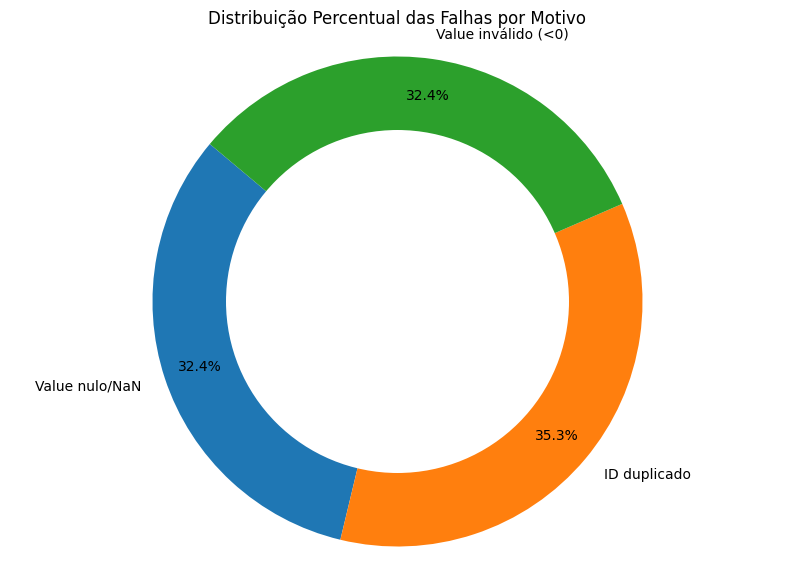

In [11]:
print("Gerando gráfico de distribuição de falhas...")

# Agrupar por motivo e contar as ocorrências
motivos_counts = df_relatorio_falhas.groupBy("motivo").agg(count("*").alias("quantidade"))

# Coletar os dados para plotagem
data_for_plot = motivos_counts.collect()

labels = [row["motivo"] for row in data_for_plot]
sizes = [row["quantidade"] for row in data_for_plot]

# Criar o gráfico de pizza
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# Adicionar um círculo branco no centro para fazer um gráfico de rosca
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Distribuição Percentual das Falhas por Motivo")
plt.axis('equal') # Garante que o gráfico de pizza seja um círculo.
plt.show()

In [12]:
distinct_error_ids = df_relatorio_falhas.select("id").distinct()
print(f"Total de IDs de pedidos distintos com falhas: {distinct_error_ids.count()}")
distinct_error_ids.show()

Total de IDs de pedidos distintos com falhas: 54491
+------+
|    id|
+------+
| 60907|
|151390|
| 65367|
|180394|
| 89230|
| 68524|
| 98677|
|171281|
| 91115|
|169075|
|  3502|
|183316|
| 61644|
| 58142|
|148682|
|186815|
|199107|
|192978|
|364090|
|187704|
+------+
only showing top 20 rows


In [13]:
total_orders = df_pedidos.count()
impacted_orders = distinct_error_ids.count()
impact_percentage = (impacted_orders / total_orders) * 100

print(f"Total de pedidos: {total_orders}")
print(f"Pedidos impactados por falhas: {impacted_orders}")
print(f"Percentual de impacto: {impact_percentage:.2f}%")

Total de pedidos: 1100000
Pedidos impactados por falhas: 54491
Percentual de impacto: 4.95%


# 2: Agregação de Dados

In [14]:
df_pedidos_validos = df_pedidos.join(distinct_error_ids, df_pedidos.id == distinct_error_ids.id, "left_anti").orderBy(asc("client_id"))

print(f"Total de pedidos válidos: {df_pedidos_validos.count()}")
df_pedidos_validos.show()

Total de pedidos válidos: 940493
+--------+---------+-----+
|      id|client_id|value|
+--------+---------+-----+
|42956630|        0|97.76|
|61406078|        0|98.87|
|40126872|        0|53.42|
|94917061|        0|71.98|
|26450305|        0|63.59|
|47842025|        0|91.26|
|93990670|        0|40.21|
|63846121|        0|72.78|
|77084155|        0|81.11|
|60905344|        0|40.44|
|60915498|        0|97.63|
|27491246|        0| 2.98|
|45382119|        0|54.58|
|32521217|        0|32.23|
|27079635|        0|90.37|
| 2029716|        0|15.55|
|94723286|        0|71.78|
|71469335|        0|41.17|
|33438149|        0|70.66|
|83358716|        0|35.80|
+--------+---------+-----+
only showing top 20 rows


In [15]:
# 1. Join especificando as tabelas e usando apelidos (aliases) para clareza
df_analise_clientes = df_pedidos_validos.alias("pedidos").join(
    df_clients.alias("clientes"),
    col("pedidos.client_id") == col("clientes.id"),
    "inner"
)

# 2. Agregação por Cliente
df_agregado = df_analise_clientes.groupBy(
    col("clientes.id"),
    col("clientes.name")
).agg(
    count(col("pedidos.id")).alias("quantidade_pedidos"),
    spark_sum(col("pedidos.value")).alias("valor_total_bruto")
)

# 3. Formatação Final e Ordenação
df_resultado_final = df_agregado.select(
    col("clientes.id").alias("id_cliente"),
    col("name").alias("nome_cliente"),
    col("quantidade_pedidos"),
    col("valor_total_bruto").cast("decimal(11,2)").alias("valor_total")
).orderBy(desc("valor_total"))

df_resultado_final.show()

+----------+---------------+------------------+-----------+
|id_cliente|   nome_cliente|quantidade_pedidos|valor_total|
+----------+---------------+------------------+-----------+
|    123456|  Inês Siqueira|            469734|23698016.90|
|      9047|   Zachary Reis|                61|    4002.08|
|      4494|  Vitor Marques|                68|    3937.06|
|      2695|    Wanda Silva|                61|    3736.53|
|      2756|  Inês Siqueira|                60|    3735.58|
|      8566|    Tereza Leal|                66|    3731.10|
|      6135|   Mariana Melo|                71|    3700.71|
|      5221|Yasmin Carvalho|                65|    3679.35|
|      9266|    Tereza Leal|                67|    3678.17|
|      2379| Gustavo Pontes|                65|    3657.84|
|      8317|   Sofia Castro|                66|    3656.86|
|      7543|Vitória Andrade|                69|    3656.43|
|       849|   Breno Soares|                66|    3651.20|
|      6532|   João Batista|            

In [16]:
# Soma total da coluna quantidade_pedidos
total_pedidos = df_resultado_final.agg(
    spark_sum("quantidade_pedidos").alias("total_pedidos")
).collect()[0]["total_pedidos"]

print(f"Total de pedidos realizados (soma de quantidade_pedidos): {total_pedidos}")


Total de pedidos realizados (soma de quantidade_pedidos): 940493


# 3: Análise Estatística

In [17]:
# Média aritmética
media_valor_total = df_resultado_final.agg(
    avg(col("valor_total")).alias("media")
).collect()[0]["media"]

# Mediana (percentil 50)
mediana_valor_total = df_resultado_final.agg(
    percentile_approx(col("valor_total"), 0.5).alias("mediana")
).collect()[0]["mediana"]

# Percentil 10 (10% inferiores)
percentil_10 = df_resultado_final.agg(
    percentile_approx(col("valor_total"), 0.1).alias("percentil_10")
).collect()[0]["percentil_10"]

# Percentil 90 (10% superiores)
percentil_90 = df_resultado_final.agg(
    percentile_approx(col("valor_total"), 0.9).alias("percentil_90")
).collect()[0]["percentil_90"]

# Exibição dos resultados
print("### 3. Análise Estatística")
print(f"Média aritmética: {media_valor_total}")
print(f"Mediana: {mediana_valor_total}")
print(f"Percentil 10 (10% inferiores): {percentil_10}")
print(f"Percentil 90 (10% superiores): {percentil_90}")


### 3. Análise Estatística
Média aritmética: 4746.437755
Mediana: 2368.14
Percentil 10 (10% inferiores): 1880.32
Percentil 90 (10% superiores): 2888.44


# 4: Filtragem - Acima da Média

In [18]:
df_acima_media = df_resultado_final.filter(
    col("valor_total") > media_valor_total
).orderBy(desc("valor_total"))

df_acima_media.show()


+----------+-------------+------------------+-----------+
|id_cliente| nome_cliente|quantidade_pedidos|valor_total|
+----------+-------------+------------------+-----------+
|    123456|Inês Siqueira|            469734|23698016.90|
+----------+-------------+------------------+-----------+



# 5: Filtragem - Média Truncada

In [19]:
df_media_truncada = df_resultado_final.filter(
    (col("valor_total") >= percentil_10) &
    (col("valor_total") <= percentil_90)
).orderBy(desc("valor_total"))

print("Clientes dentro da média truncada (P10–P90)")
df_media_truncada.show()


Clientes dentro da média truncada (P10–P90)
+----------+------------------+------------------+-----------+
|id_cliente|      nome_cliente|quantidade_pedidos|valor_total|
+----------+------------------+------------------+-----------+
|      6780|     Heloísa Brito|                58|    2888.44|
|      5477|Emerson Figueiredo|                50|    2887.94|
|      2931|     Isabela Nunes|                53|    2887.75|
|      2927|      Elisa Campos|                48|    2887.42|
|       125|    Camila Freitas|                49|    2886.89|
|      5710|     Kevin Pereira|                50|    2886.74|
|      5576|     Débora Cortez|                50|    2886.68|
|      4883|   Klaus Magalhães|                60|    2886.42|
|      6043|   Vitória Andrade|                52|    2885.94|
|      8430|   Henrique Farias|                59|    2885.52|
|      5325|    Camila Freitas|                50|    2885.51|
|      3813|   Natália Ribeiro|                55|    2885.40|
|      3905